In [103]:
import numpy as np
from pylab import *
from scipy import ndimage
from scipy import misc
from scipy import linalg
from scipy import argsort
from scipy import signal
from scipy import interpolate
import os
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py as h5

%matplotlib inline

rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session

# Set up ND fiber angle code

In [167]:
def ndautocorr(V, insz, window=None, beta=1, normalize=True):
    '''Autocorrelation of a volume with a smaller subvolume of itself. 
    Should work on 3D and 2D "volumes"'''
    outsz = V.shape

    if normalize:
        V = (V-np.mean(V))/np.ptp(V)
        
    if window is not None:
        if window == 'hamming':
            windowfcn = np.hamming
        elif window == 'kaiser':
            windowfcn = lambda x: np.kaiser(x,beta=beta)
        else:
            raise ValueError('Unrecognized window function')
        
        W = np.ones((outsz[0]))
        for dim1,outsz1 in enumerate(outsz):
            #make the window on one axis
            w1 = windowfcn(outsz1)
            #set up a slice to broadcast along the current dimension
            ss = [np.newaxis for i in outsz]
            ss[dim1] = slice(None)
            #and multiply to build up the ND window
            W = W * w1[ss]
        
        V = V*W
        
    inrng = [slice(out1//2-in1//2, out1//2-in1//2 + in1)
            for (in1,out1) in zip(insz,outsz)]
    outrng = [slice(None,None,-1) for in1 in insz]
    
    C = signal.fftconvolve(V[outrng],V[inrng],mode='valid')
    
    return C

## Test autocorrelation

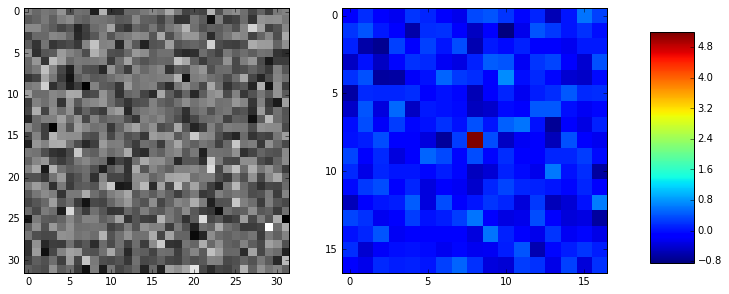

In [105]:
I1 = np.random.randn(32,32)
C = ndautocorr(I1,insz=(16,16),window='kaiser')

fig,axes = subplots(1,2)

axes[0].imshow(I1,cmap=cm.gray, interpolation='nearest')

im = axes[1].imshow(C, interpolation='nearest')

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.85, 0.3, 0.05, 0.4])
fig.colorbar(im, cax=cax)

show()

These should be equal, or at least close if we used a window

In [107]:
print np.max(C)
print np.sum(((I1[8:-8,8:-8]-np.mean(I1))/np.ptp(I1))**2)

5.18838874799
5.60046014234


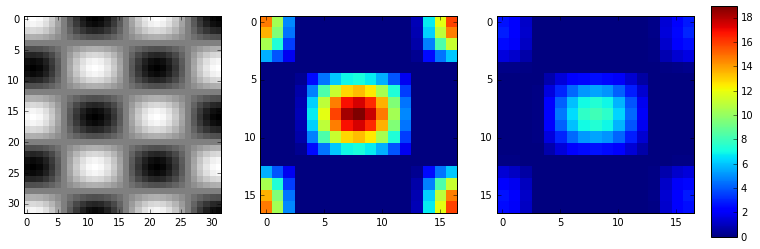

In [108]:
i,j = np.meshgrid(range(-16,16),range(-16,16))
I1 = np.sin(2*np.pi*i/20) * np.cos(2*np.pi*j/16)

C1 = ndautocorr(I1,insz=(16,16))
C2 = ndautocorr(I1,insz=(16,16),window='hamming')

fig,ax = subplots(1,3)
ax[0].imshow(I1,cmap=cm.gray, interpolation='nearest')

im = ax[1].imshow(C1, interpolation='nearest')
im.set_clim(0,np.max(C1))

im = ax[2].imshow(C2, interpolation='nearest')
im.set_clim(0,np.max(C1))

fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.3, 0.03, 0.4])
fig.colorbar(im, cax=cax)

show()

In [109]:
print np.max(C1)
print np.sum(((I1[8:-8,8:-8]-np.mean(I1))/np.ptp(I1))**2)
print C1[8,8]
print np.max(C2)
print C2[8,8]

18.9270509831
18.9270509831
18.9270509831
8.12975116532
8.12975116532


## Test with lines

In [110]:
def generate_line_image(sz,ang,k):
    szhi = sqrt(2)*sz
    
    a0 = np.arange(szhi)
    a0 = a0 - a0[-1]/2
    b0 = a0.copy()
    a,b = np.atleast_2d(a0,b0)
    b = b.T

    #need the np.ones_line so that it broadcasts and we get a matrix
    #that is [len(a),len(b)] in shape
    I0 = cos(2*pi*k/sz*b) * np.ones_like(a)
    
    i0 = np.arange(sz)
    i0 = i0 - i0[-1]/2
    j0 = i0.copy()
    i0,j0 = np.atleast_2d(i0,j0)
    i0 = i0.T
    
    i = i0*np.cos(ang) + j0*np.sin(ang)
    j = -i0*np.sin(ang) + j0*np.cos(ang)
    
    fcn = interpolate.RectBivariateSpline(a0,b0,I0)
    I = fcn(i,j,grid=False)
    
    return I,np.squeeze(i0),np.squeeze(j0)

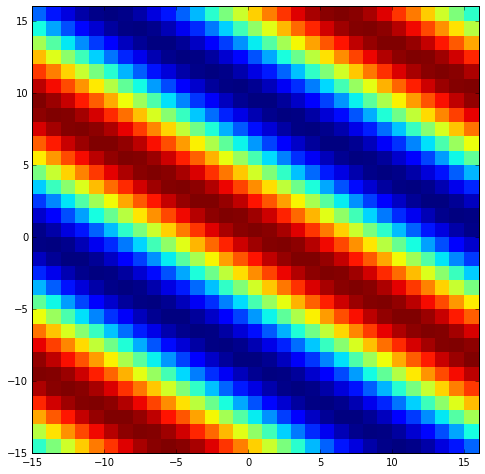

In [111]:
I,i,j = generate_line_image(32,30*np.pi/180, 2)
pcolormesh(i,j,I)
axis('square')
gca().autoscale(tight=True)
show()

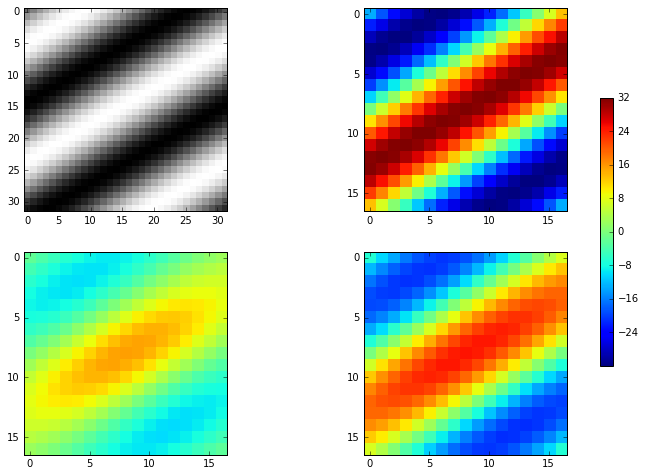

In [112]:
C1 = ndautocorr(I,insz=(16,16))
C2 = ndautocorr(I,insz=(16,16), window='hamming')
C3 = ndautocorr(I,insz=(16,16), window='kaiser', beta=2)

fig,ax = subplots(2,2)
ax[0,0].imshow(I,cmap=cm.gray, interpolation='nearest')

ax[0,1].imshow(C1, interpolation='nearest')

im = ax[1,0].imshow(C2, interpolation='nearest')
im.set_clim(np.min(C1),np.max(C1))

im = ax[1,1].imshow(C3, interpolation='nearest')
im.set_clim(np.min(C1),np.max(C1))

fig.colorbar(im, ax=ax.ravel().tolist(), fraction=0.02)

show()

In [113]:
def hessian(C, ctr=None, di=1):
    #5th order derivatives
    #first derivative
    a1 = np.array([-1.0, 9.0, -45.0, 0.0, 45.0, -9.0, 1.0])/60
    #second derivative
    a2 = np.array([2, -27, 270, -490, 270, -27, 2])/180.0

    #round down
    n = len(a1)//2
    if ctr is None:
        #round up if lengths are odd
        ctr = (np.array(C.shape)+1)//2
    
    ic = np.arange(-n,n+1)
    
    nd = C.ndim
    assert((nd == 2) or (nd == 3))
    
    H = np.zeros((nd,nd))
    
    #get second derivatives along the diagonal
    for i in xrange(nd):
        r = list(ctr)
        r[i] += ic
        H[i,i] = sum(C[tuple(r)] * a2) / di**2
    
    #cross derivatives off diagonal
    ic1 = ic[:,np.newaxis]
    ic2 = ic[np.newaxis,:]

    for i in xrange(nd):
        for j in xrange(i+1,nd):
            r = list(ctr)
            r[i] += ic1
            r[j] += ic2
            H[i,j] = np.sum( np.sum( C[tuple(r)] * a1[:,np.newaxis], axis=0) * a1) / di**2
            
            #mirror the cross derivatives
            H[j,i] = H[i,j]
    
    return H    

In [114]:
def fiber_angle(V, insz, returncorr=False, **kw):
    #get the autocorrelation
    C = ndautocorr(V, insz, **kw)
    ctr = (np.array(V.shape) - np.array(insz)+1)//2
    
    #and the hessian in the center
    H = hessian(C, ctr=ctr)
    
    #then eigenvalues and eigenvectors of the Hessian matrix
    w,vr = linalg.eig(H)
    
    #look for the smallest magnitude eigenvalue
    ord = argsort(np.abs(w))
    vr = vr[:,ord]
    w = w[ord]

    if returncorr:
        return vr,w, C
    else:
        return vr,w

## Check line angle

[array([ -9.32645139e-06,  -4.84728279e+00]), array([-0.23843392, -2.66618553]), array([-0.13841167, -3.98093597])]


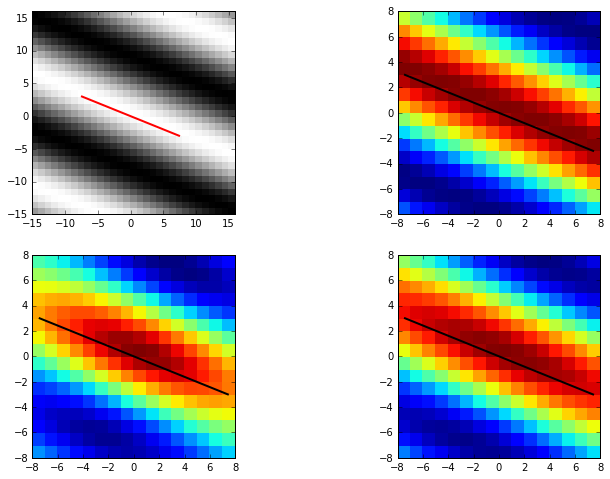

In [115]:
ang = 22*np.pi/180
I,i,j = generate_line_image(32,ang, 2)

#true angle
u0 = np.cos(-ang)/2
v0 = np.sin(-ang)/2

#autocorrelation
vr1,w1,C1 = fiber_angle(I,insz=(16,16), returncorr=True)
vr2,w2,C2 = fiber_angle(I,insz=(16,16), returncorr=True, window='hamming')
vr3,w3,C3 = fiber_angle(I,insz=(16,16), returncorr=True, window='kaiser',beta=2)

a = np.arange(C1.shape[0]) - C1.shape[0]//2
b = np.arange(C1.shape[1]) - C1.shape[1]//2

fig,ax = subplots(2,2)
ax[0,0].pcolormesh(i,j,I,cmap=cm.gray)
ax[0,0].plot(16*np.array([-u0, u0]), 16*np.array([-v0,v0]), 'r-', linewidth=2.0)

ax[0,1].pcolormesh(a,b,C1)
ax[0,1].plot(8*np.array([-vr1[1,0], vr1[1,0]]), 8*np.array([-vr1[0,0],vr1[0,0]]), 'k-', linewidth=2.0)

ax[1,0].pcolormesh(a,b,C2)
ax[1,0].plot(8*np.array([-vr2[1,0], vr2[1,0]]), 8*np.array([-vr2[0,0],vr2[0,0]]), 'k-', linewidth=2.0)

ax[1,1].pcolormesh(a,b,C3)
ax[1,1].plot(8*np.array([-vr3[1,0], vr3[1,0]]), 8*np.array([-vr3[0,0],vr3[0,0]]), 'k-', linewidth=2.0)

for ax1 in ax.flat:
    ax1.set_aspect('equal')
    ax1.autoscale(tight=True)
    
print [np.real(w1),np.real(w2),np.real(w3)]

## Look in Danio image

In [116]:
infile = 'Drerio4.h5'

In [117]:
f = h5.File(infile,'a')
imgdata = f['image']
print imgdata.shape

(690, 1235, 2237)


## Make a grid

In [230]:
gridsize = 48
gridi = np.arange(gridsize,imgdata.shape[1]-gridsize,gridsize)
gridj = np.arange(gridsize,imgdata.shape[2]-gridsize,gridsize)

Make the grid into a list of point locations and indices

Example grid square

In [231]:
print (len(gridi),len(gridj))

(24, 45)


In [236]:
exind = (8,20)
print (gridi[exind[0]],gridj[exind[1]])

(432, 1008)


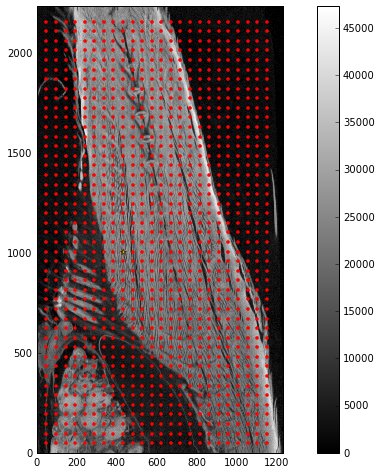

In [238]:
I = np.array(imgdata[300,:,:])
imshow(I.T, cmap=cm.gray, origin='lower')
colorbar()

ii,jj = np.meshgrid(gridi,gridj)
plot(ii,jj,'r.', gridi[exind[0]],gridj[exind[1]],'y*')

gca().set_aspect('equal')
autoscale(tight=True)

show()

Load one grid square and check the result

In [239]:
gridsz2 = (gridsize+1)//2
rng = [slice(grid11-gridsz2,grid11+gridsz2) for grid11 in [gridi[exind[0]],gridj[exind[1]]]]
I1 = I[rng].astype(float)/65536

Look at the inner and outer regions

In [240]:
np.max(I1)

0.4750823974609375

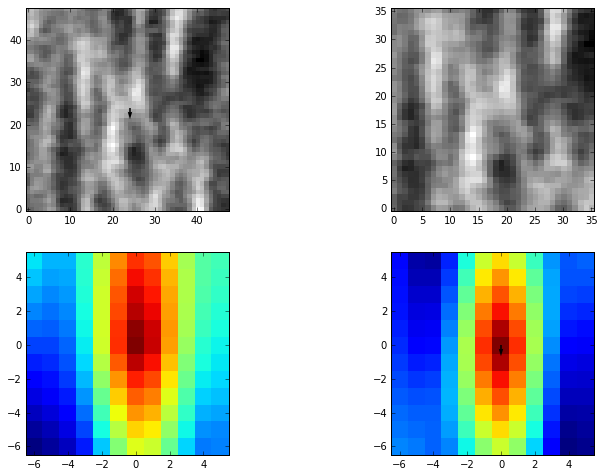

In [241]:
outsz = I1.shape
insz = (36,36)

inrng = [slice(out1//2-in1//2, out1//2-in1//2 + in1)
        for (in1,out1) in zip(insz,outsz)]
outrng = [slice(None,None,-1) for in1 in insz]

I2 = 1-I1
I2 = (I2 - np.min(I2))/np.ptp(I2)

C = signal.fftconvolve(I2[outrng],I2[inrng],mode='valid')

i = np.arange(13.0)-6.5
j = np.arange(13.0)-6.5
i,j = np.meshgrid(i,j)

vr2,w2,C2 = fiber_angle(I2, insz=(36,36), returncorr=True, window='hamming')

fig,ax = subplots(2,2)
ax = ax.flatten()
ax[0].imshow(I2.T,cmap=cm.gray,interpolation='nearest', origin='lower')
ax[0].quiver([24,],[24,],vr2[0,0],vr2[1,0])

ax[1].imshow(I2[inrng].T,cmap=cm.gray,interpolation='nearest', origin='lower')

ax[2].pcolormesh(i,j, C.T)
ax[2].set_aspect('equal')
ax[2].autoscale(tight=True)

ax[3].pcolormesh(i,j,C2.T)
ax[3].quiver([0,],[0,],vr2[0,0],vr2[1,0])
ax[3].set_aspect('equal')
ax[3].autoscale(tight=True)
show()

In [242]:
vr1,w1,C1 = fiber_angle(I1, insz=(36,36), returncorr=True)
vr2,w2,C2 = fiber_angle(I1, insz=(36,36), returncorr=True, window='hamming')
vr3,w3,C3 = fiber_angle(I1, insz=(36,36), returncorr=True, window='kaiser', beta=1)

In [243]:
print np.real_if_close(w1)
print vr1

[ -5.06983863 -14.82279321]
[[-0.02128092 -0.99977354]
 [-0.99977354  0.02128092]]


In [244]:
print np.real_if_close(w2)
print vr2

[-1.35371049 -4.23927211]
[[-0.00276111 -0.99999619]
 [-0.99999619  0.00276111]]


In [245]:
print np.real_if_close(w2)
print vr2

[-1.35371049 -4.23927211]
[[-0.00276111 -0.99999619]
 [-0.99999619  0.00276111]]


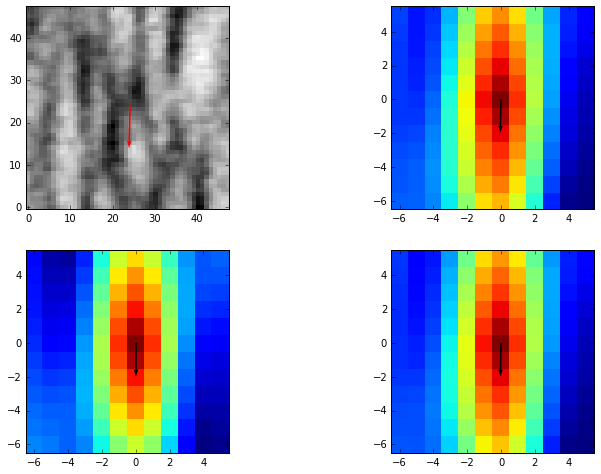

In [246]:
ctr1 = (24,24)
i = np.arange(13.0)-6.5
j = np.arange(13.0)-6.5
i,j = np.meshgrid(i,j)

fig,ax = subplots(2,2)
ax = ax.flatten()
ax[0].imshow(I1.T,cmap=cm.gray, interpolation='nearest', origin='lower')
ax[0].quiver(ctr1[0],ctr1[1],vr1[0,0],vr1[1,0],angles='xy',color='r',scale=0.1,scale_units='xy')

ax[1].pcolormesh(i,j,C1.T)
ax[1].quiver([0,],[0,],vr1[0,0],vr1[1,0],angles='xy',color='k',scale=0.5,scale_units='xy')
ax[1].set_aspect('equal')
ax[1].autoscale(tight=True)

ax[2].pcolormesh(i,j,C2.T)
ax[2].quiver([0,],[0,],vr2[0,0],vr2[1,0],angles='xy',color='k',scale=0.5,scale_units='xy')
ax[2].set_aspect('equal')
ax[2].autoscale(tight=True)

ax[3].pcolormesh(i,j,C3.T)
ax[3].quiver([0,],[0,],vr3[0,0],vr3[1,0],angles='xy',color='k',scale=0.5,scale_units='xy')
ax[3].set_aspect('equal')
ax[3].autoscale(tight=True)

show()

In [247]:
gridsz2 = (gridsize+1)//2

sz = (len(gridi),len(gridj))
eigvecs = np.zeros((2,2) + sz)
eigvals = np.zeros((2,) + sz)
insz = (36,36)

Inorm = I.astype(float)/65536
Inorm = (Inorm - np.mean(Inorm)) / np.std(Inorm)

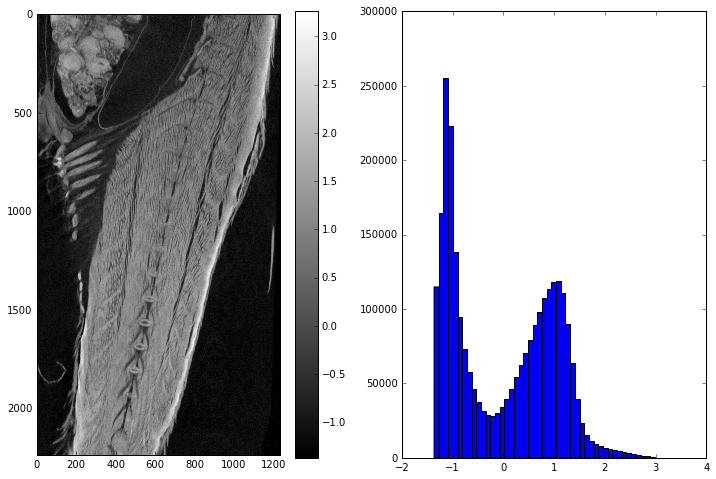

In [248]:
fig,ax = subplots(1,2)

im = ax[0].imshow(Inorm.T,cmap=cm.gray)
colorbar(im, ax=ax[0])

ax[1].hist(Inorm.flatten(),50)

show()

In [249]:
eigvals.shape

(2, 24, 45)

In [250]:
for i1, gridi1 in enumerate(gridi):
    for j1, gridj1 in enumerate(gridj):
        rng = [slice(grid11-gridsz2,grid11+gridsz2) for grid11 in [gridi1,gridj1]]

        I1 = Inorm[rng]
        if I1.size == 0:
            print "bad slice: {}".format(grid1)

        if np.mean(I1) > -0.5:
            vr1,w1 = fiber_angle(I1, insz=insz, normalize=False)

            eigvals[:,i1,j1] = real(w1)
            eigvecs[:,:,i1,j1] = vr1

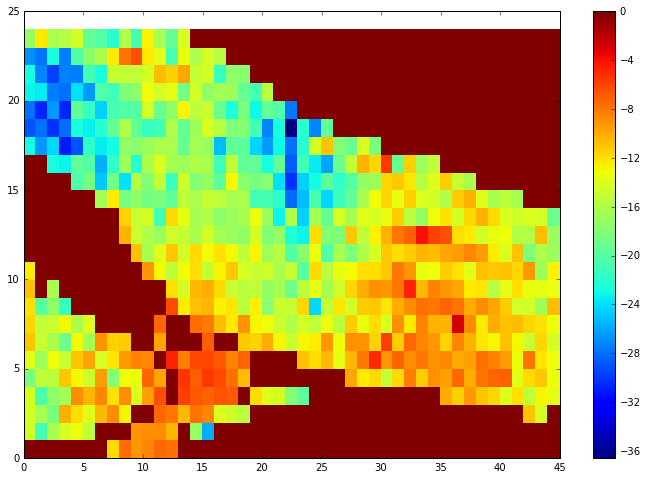

In [253]:
fig,ax = subplots()
im = ax.pcolormesh(eigvals[0,:,:])
colorbar(im,ax=ax)
show()

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in divide


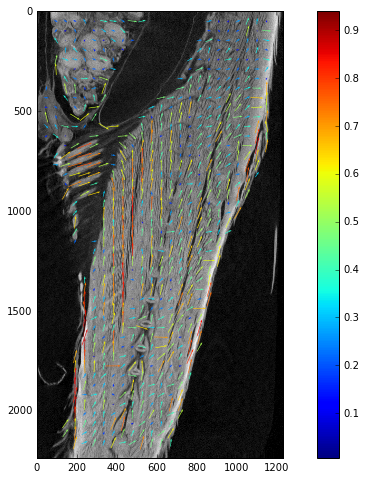

In [276]:
%matplotlib inline
rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session

ii,jj = np.meshgrid(gridi,gridj, indexing='ij')

imshow(Inorm.T,cmap=cm.gray)
vecscale = 1 - eigvals[0,:,:]/eigvals[1,:,:]
quiver(ii,jj,eigvecs[0,0,:,:]*vecscale,eigvecs[1,0,:,:]*vecscale, vecscale, pivot='mid',
      angles='xy',scale=0.05,scale_units='dots')
colorbar()
show()

In [277]:
sz = (len(gridi),len(gridj))
eigvecs2 = np.zeros((2,2) + sz)
eigvals2 = np.zeros((2,) + sz)

I2 = I.astype(float)/65536
Imn = np.mean(I2)
Istd = np.std(I2)

for i1, gridi1 in enumerate(gridi):
    for j1, gridj1 in enumerate(gridj):
        rng = [slice(grid11-gridsz2,grid11+gridsz2) for grid11 in [gridi1,gridj1]]

        I1 = I2[rng]
        if I1.size == 0:
            print "bad slice: {}".format(grid1)

        if np.mean((I1-Imn)/Istd) > -0.5:
            vr1,w1 = fiber_angle(I1, insz=insz, normalize=True)

            eigvals2[:,i1,j1] = real(w1)
            eigvecs2[:,:,i1,j1] = vr1

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


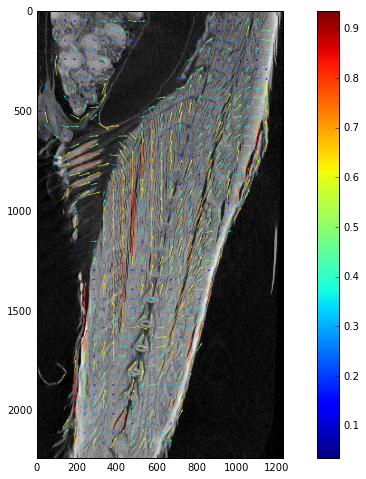

In [278]:
ii,jj = np.meshgrid(gridi,gridj, indexing='ij')

imshow(I2.T,cmap=cm.gray)
vecscale = 1 - eigvals2[0,:,:]/eigvals2[1,:,:]
quiver(ii,jj,eigvecs2[0,0,:,:]*vecscale,eigvecs2[1,0,:,:]*vecscale, vecscale, pivot='mid',
      angles='xy',scale=0.05,scale_units='dots')
colorbar()
show()